# Exercise 4

## Import packages

In [43]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [44]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ' \
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [45]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [46]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run network layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [53]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        # Initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        
        # Apply layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [48]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
    def forward(self, x):
        pass

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [49]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)  # 1x28x28 -> 32x26x26
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)  # 32x26x26 -> 64x24x24
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [50]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

    def forward(self, x):
        pass

In [51]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

    def forward(self, x):
        pass

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315564
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.641777
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.382097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.195503
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.087440
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.041985
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.103931
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.172676
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.233574
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.191167

Test set: Average loss: 0.1280, Accuracy: 9653/10000 (96.53%)



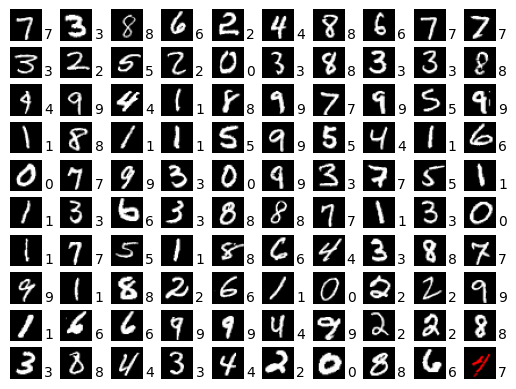

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103860
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.207182
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.103373
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.047020
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.073723
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.134461
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.080007
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.038920
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.082849
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.043874

Test set: Average loss: 0.0960, Accuracy: 9726/10000 (97.26%)



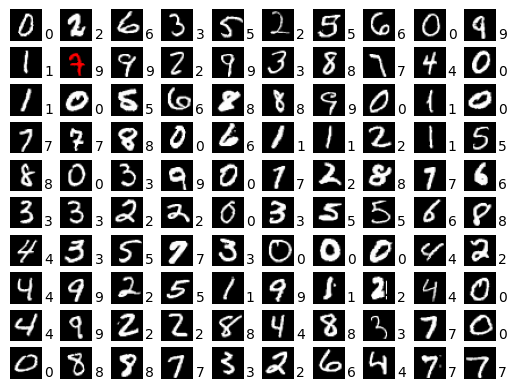

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.045784
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.023653
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.112623
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.127798
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.050604
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.029667
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.007497
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.043399
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.029821
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.001163

Test set: Average loss: 0.0835, Accuracy: 9779/10000 (97.79%)



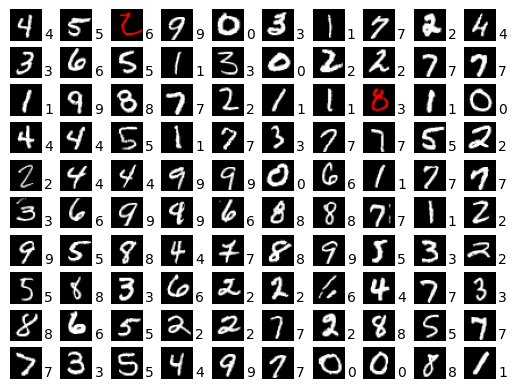

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.052386
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.002385
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.053189
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.002971
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.050788
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000383
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.060845
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.033933
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.027684
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.024882

Test set: Average loss: 0.0805, Accuracy: 9798/10000 (97.98%)



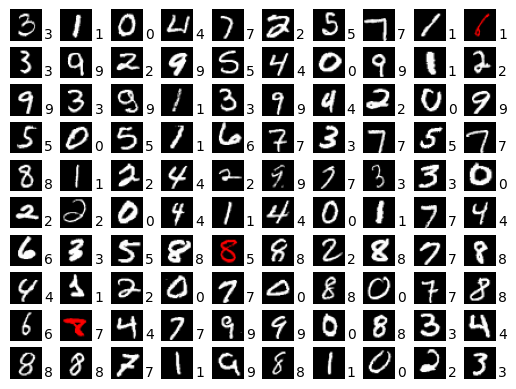

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.017700
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000508
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.006775
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.013578
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.005106
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.002055
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.004905
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.030025
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.012879
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.052401

Test set: Average loss: 0.0792, Accuracy: 9818/10000 (98.18%)



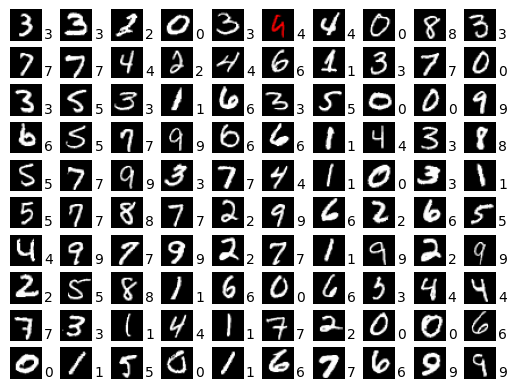

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.023184
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001935
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001858
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.006027
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000648
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000427
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001075
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001362
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.004149
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.002634

Test set: Average loss: 0.0858, Accuracy: 9814/10000 (98.14%)



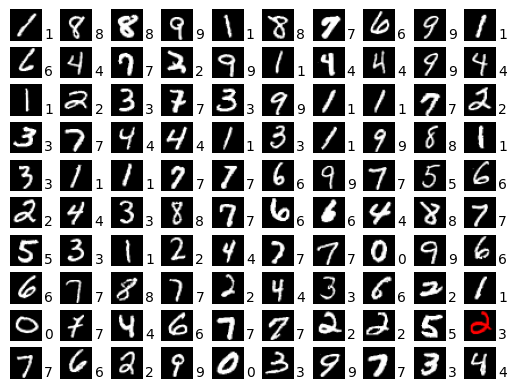

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003181
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.003854
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000195
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000985
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.007724
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000962
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.002593
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000255
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000820
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.022467

Test set: Average loss: 0.0849, Accuracy: 9828/10000 (98.28%)



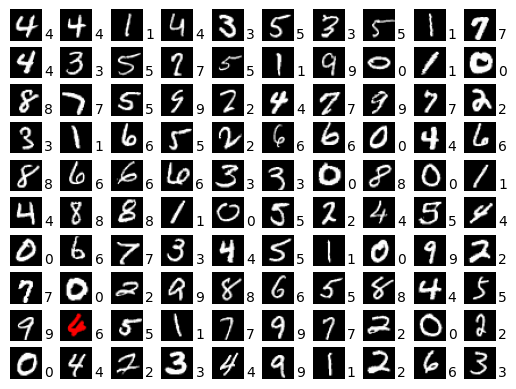

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000091
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.017753
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.068592
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000380
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000158
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000125
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.029558
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001686
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.001398
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.011192

Test set: Average loss: 0.0899, Accuracy: 9822/10000 (98.22%)



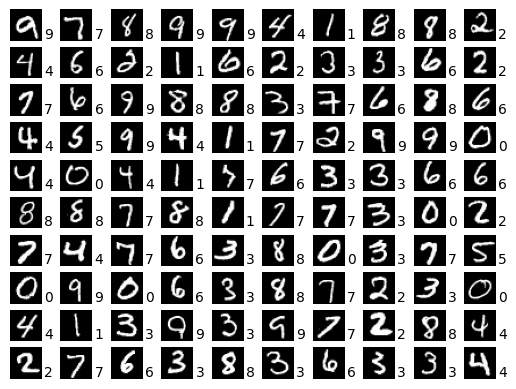

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.002073
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000832
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.002143
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001711
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000758
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.002557
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000201
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000103
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.003002
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000890

Test set: Average loss: 0.0896, Accuracy: 9833/10000 (98.33%)



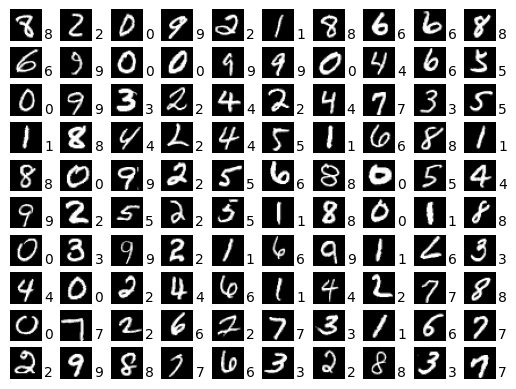

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000223
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.014459
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.002215
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.001998
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000376
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000589
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000330
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.007899
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.001034
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000017

Test set: Average loss: 0.0905, Accuracy: 9829/10000 (98.29%)



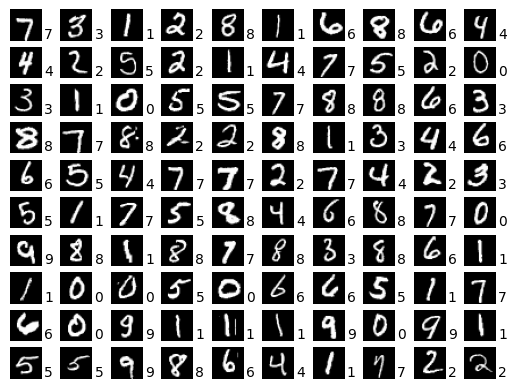

In [54]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")